In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.optimize import curve_fit
from non_linearity.environment import Particle


In [18]:
def autocor_0(t, omega, gamma, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    C = 2*(gamma*kb*T/m)
    
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18):
    kb = 1.3806e-23
    T = 293
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

def theoretical_area_frac(omega, gamma, gain, delay, m=3.368e-18):
    T0 = autocor_0(0, omega, gamma, m=m)
    T1 = autocor_perturbation(0, omega, gamma, gain, delay, m=m)
    return T1/T0

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y


def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    gain = -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution
    return 11.27*3.03e-15*np.power(-11*1.504e4*gain,3)

In [3]:
kbT = 1.38065e-23*300
m = 3.229e-18
rp_clock = 1/(100e6)

In [46]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base


def psd(path_file, windows = 10, factor=1, channel='ch1', filter_sig=True):
    data = pd.read_pickle(path_file)
    dt = data.t[1]-data.t[0]
    f = 1/dt
    freq, power = signal.welch(butter_bandpass_filter(data[channel]*factor, 1e4, 15e4, fs=f),
                                                      f, 
                                                      window = 'hamming', 
                                                      nperseg = int(len(data[channel])/windows))
    return freq, (1/np.sqrt(2*np.pi))*power


def extract_fit_interval(freq, power, bottom_limit=6e4, upper_limit=12e4):
    freq_upper = freq[freq>bottom_limit]
    freq_fit = freq_upper[freq_upper<upper_limit]
    power_upper = power[freq>bottom_limit]
    power_fit = power_upper[freq_upper<upper_limit]
    return freq_fit, power_fit


def extract_area(file, path_root, windows=20):
    freq, power = psd('{}/{}'.format(path_root, file), windows=windows)
    area = power.sum()*(np.diff(freq)[0])
    return power, freq, area

In [47]:
omega = 2*np.pi*81e3
gamma=65e3
env = Particle(omega, gamma, radius=73e-9)

In [48]:
path_root = '../data/delay/batch_0'
folders = ['8191_250_0', '12374_875_0', '4010_562_0', '12374_562_0',
 '8191_875_0', '8192_250_0', '8191_562_0', '4010_250_0',
 '12374_1023_164', '4010_875_0', '12374_250_0', '8192_1023_164',
 '8192_562_0', '8191_1023_164', '4010_1023_164', '8192_875_0']
areas_t, areas, batches, delays, d_delay, d_gains, f_gains = [], [], [], [], [], [], []

for folder in folders:
    for file in os.listdir('{}/{}'.format(path_root, folder)):
        print(file.split('.'))
        if file.split('.')[1] == 'pkl':
            power, freq, area = extract_area(file, '{}/{}'.format(path_root, folder))
            power_ref, freq_ref, area_ref = extract_area('{}'.format(file),'{}/0_{}'.format(path_root, folder))
            freq_fit, power_fit = extract_fit_interval(freq_ref, power_ref, bottom_limit=6e4, upper_limit=10e4)
            p0 =  [3963600.1039417023, 2*np.pi*79000.0, 31428.2758744481, 0]
            ans,cov = curve_fit(lorentzian, 2*np.pi*freq_fit, power_fit, p0=p0, absolute_sigma=True, maxfev=10000)
            areas.append(area/area_ref)
            gain, delay1, delay2 = [int(param) for param in folder.split('_')]
            gamma = 13578.7501
            omega = ans[1]
            print(ans)
            total_delay = rp_clock*(delay1+delay2+62)
            f_gains.append(convert_gains(gain))
            delays.append(total_delay)
            batches.append(int(file.split('.')[0]))
            d_gains.append(gain)
            d_delay.append(delay1+delay2+62)
        #plt.plot(freq, lorentzian(2*np.pi*freq, *ans))
#    plt.plot(freq, power)

['4', 'pkl']
[3.73256579e+07 5.11066612e+05 6.15814131e+04 2.19971275e-11]
['0', 'pkl']
[3.62339155e+07 5.10315214e+05 5.87522240e+04 6.36338411e-11]
['1', 'pkl']
[3.75576197e+07 5.11548578e+05 5.94385140e+04 4.64085128e-11]
['3', 'pkl']
[3.93280518e+07 5.11362210e+05 6.70008367e+04 2.26603200e-12]
['2', 'pkl']
[ 3.92834045e+07  5.10833665e+05  6.63469232e+04 -2.63879065e-12]
['4', 'pkl']
[2.79050891e+07 5.07461508e+05 6.39575657e+04 1.50258777e-11]
['0', 'pkl']
[ 2.97977634e+07  5.04493210e+05  6.82108842e+04 -4.57210436e-12]
['1', 'pkl']
[ 3.04321669e+07  5.05952827e+05  6.92606420e+04 -6.00749516e-12]
['3', 'pkl']
[2.73543058e+07 5.07684883e+05 6.37251152e+04 1.90344969e-11]
['2', 'pkl']
[2.65675097e+07 5.07948923e+05 6.22850233e+04 3.89972256e-11]
['4', 'pkl']
[3.20797788e+07 5.09442388e+05 6.70942320e+04 8.38217423e-12]
['0', 'pkl']
[3.30122893e+07 5.06617359e+05 6.52356102e+04 2.54722681e-11]
['1', 'pkl']
[3.31627052e+07 5.09525005e+05 6.41342696e+04 1.47305594e-11]
['3', 'pkl']


In [50]:
df = pd.DataFrame()
df['gain'] = f_gains
df['digital_gain'] = d_gains
df['batch'] = batches
df['area'] = areas
df['delay'] = delays
df['digital_delay'] = d_delay

ValueError: Length of values (5000) does not match length of index (80)

In [ ]:
def get_plot_params(df):
    gains = df.groupby(['digital_gain', 'digital_delay'], as_index=False)['gain'].mean()
    means = df.groupby(['digital_gain', 'digital_delay'], as_index=False)['area'].mean()
    std = df.groupby(['digital_gain', 'digital_delay'], as_index=False)['area'].std()
    return gains, means, std

In [ ]:
plot_df = df.groupby(['digital_gain', 'digital_delay'], as_index=False).aggregate({'area':['mean', 'std'],
                                                                                  'gain': 'mean',
                                                                                  'delay': 'mean'})
plot_df['area_mean'] = plot_df['area']['mean']
plot_df['gain_mean'] = plot_df['gain']['mean']
plot_df['delay_mean'] = plot_df['delay']['mean']
plot_df['area_std'] = plot_df['area']['std']
plot_df = plot_df.drop('area', axis=1)
plot_df = plot_df.drop('gain', axis=1)
plot_df = plot_df.drop('delay', axis=1)
plot_df.head(30)

/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_21122/3423421414.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_df = plot_df.drop('area', axis=1)
/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_21122/3423421414.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_df = plot_df.drop('gain', axis=1)
/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_21122/3423421414.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_df = plot_df.drop('delay', axis=1)


,digital_gain,digital_delay,area_mean,gain_mean,delay_mean,area_std
,,,,,,
0,4010,312,1.029529,-5.942940e+05,0.000003,0.013386
1,4010,624,1.183882,-5.942940e+05,0.000006,0.026633
2,4010,937,0.950081,-5.942940e+05,0.000009,0.013238
3,4010,1249,0.813848,-5.942940e+05,0.000012,0.007129
4,8191,312,5.506364,-5.064995e+06,0.000003,0.125163
5,8191,624,1.186847,-5.064995e+06,0.000006,0.018126
6,8191,937,0.767143,-5.064995e+06,0.000009,0.014026
7,8191,1249,0.851128,-5.064995e+06,0.000012,0.008024
8,8192,312,0.730791,5.066850e+06,0.000003,0.017690


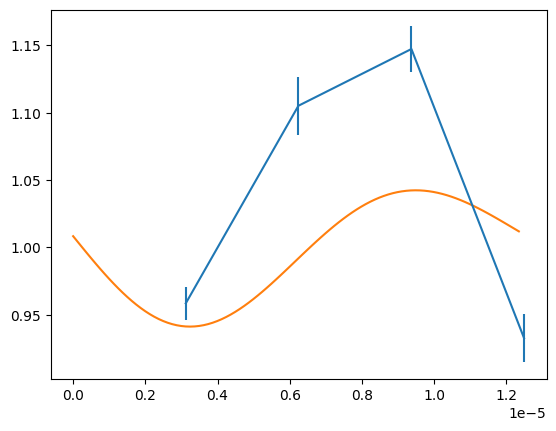

In [ ]:
plot_df = plot_df.sort_values(by='delay_mean')

delays = np.linspace(0, 1.2e-5, 5000)

#plt.errorbar(gains[::5]/1e6, median_shifts[::5]/1e3, yerr=std[::5]/1e3, 
#             fmt='o', color=colors[0], markersize=4)   


plt.errorbar(plot_df[plot_df['digital_gain']==12374]['delay_mean'].values,
             plot_df[plot_df['digital_gain']==12374]['area_mean'].values,
            plot_df[plot_df['digital_gain']==12374]['area_std'].values)

#plt.plot(plot_df[plot_df['digital_gain']==8191]['delay'].values, plot_df[plot_df['digital_gain']==8191]['area_t'].values)


theory_delays = np.linspace(0, 2*np.pi/env.__omega__, 100)
areas_t = theoretical_area_frac(env.__omega__, env.__gamma__, -5.9e5/env._m_, theory_delays, m=env._m_)

plt.plot(theory_delays, areas_t)



plt.show()

In [51]:
df.groupby(['digital_gain', 'digital_delay'], as_index=False)['gain'].mean()

KeyError: 'digital_delay'

In [ ]:

plot_df

digital_gain digital_delay      area                    gain     delay
                                   mean       std          mean      mean
0          4010           250  1.029529  0.013386 -5.942940e+05  0.000003
1          4010           562  1.183882  0.026633 -5.942940e+05  0.000006
2          4010           875  0.950081  0.013238 -5.942940e+05  0.000009
3          4010          1187  0.813848  0.007129 -5.942940e+05  0.000012
4          8191           250  5.506364  0.125163 -5.064995e+06  0.000003
5          8191           562  1.186847  0.018126 -5.064995e+06  0.000006
6          8191           875  0.767143  0.014026 -5.064995e+06  0.000009
7          8191          1187  0.851128  0.008024 -5.064995e+06  0.000012
8          8192           250  0.730791  0.017690  5.066850e+06  0.000003
9          8192           562  1.128742  0.017153  5.066850e+06  0.000006
10         8192           875  8.556944  0.373059  5.066850e+06  0.000009
11         8192          1187  1.369116  0.066075  5.066850e+06  0.000012
12        12374           250  0.958531  0.012430  5.942940e+05  0.000003
13        12374           562  1.105041  0.021500  5.942940e+05  0.000006
14        12374           875  1.147139  0.016820  5.942940e+05  0.000009
15        12374          1187  0.932726  0.017954  5.942940e+05  0.000012

In [ ]:
root_folder = '../data/delay/batch_0'
p = []
plt.figure() 

#folders = ['0_4010_250_0', '4010_250_0']#, '4010_562_0', '0_4010_250_0']


areas = []
areas_t = []
for folder in folders:
    freq, power = psd('{}/{}'.format(root_folder, folder), factor=1/(11*1.504e4))
    area = power.sum()*np.diff(freq)[0]
    
    
    
    freq, power = psd('{}/0_{}'.format(root_folder, folder), factor=1/(11*1.504e4))
    freq_fit, power_fit = extract_fit_interval(freq, power, bottom_limit=7e4, upper_limit=9e4)
    ref_area = power.sum()*np.diff(freq)[0]
    gain, delay1, delay2 = [int(param) for param in folder.split('_')]
    areas.append(area/ref_area)



    p0 =  [3963600.1039417023, 2*np.pi*79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, 2*np.pi*freq_fit, power_fit, p0=p0, absolute_sigma=True, maxfev=10000)
    gamma = 13578.7501
    omega = ans[1]
    gain, delay1, delay2 = [int(param) for param in folder.split('_')]
    total_delay = rp_clock*(delay1+delay2)
    T0 = autocor_0(0, omega, gamma)
    T1 = autocor_perturbation(0, omega, gamma, -convert_gains(gain)/m, total_delay)
    areas_t.append(abs(T1)/abs(T0))
        

<Figure size 640x480 with 0 Axes>

In [451]:
areas, areas_t

([5.492884130172078,
  1.1512945464968942,
  1.1899757330464142,
  1.1138381998615376,
  0.7714926313455501,
  0.7269237051277708,
  1.1824369112615298,
  1.0327676121473046,
  0.9292646012770147,
  0.9511218764375943,
  0.9579931753024225,
  1.390289066286708,
  1.1338226816296453,
  0.8496820721185184,
  0.8142289207553361,
  8.474333937107344],
 [3.8032265620406083,
  1.3232892412192117,
  1.096159148180361,
  0.9032149577571615,
  1.6551600346978503,
  1.7687004712907324,
  1.8345220497869652,
  1.3369875870579175,
  1.0691511491159773,
  0.682708257617923,
  0.6736553751384352,
  1.6481104705520964,
  1.4127824958785438,
  0.3150681547673821,
  0.9345304848401166,
  3.6525341090273735])

(0.0, 8.0)

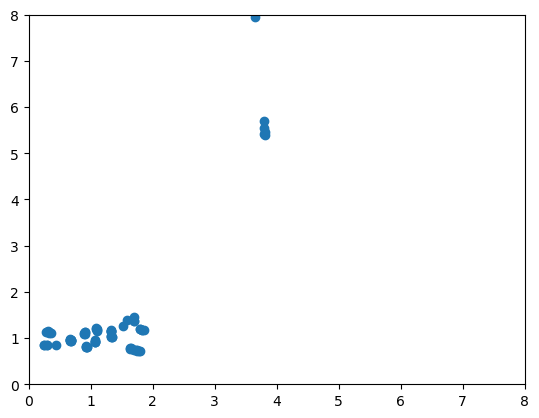

In [571]:
plt.scatter(areas_t, areas)
plt.xlim([0,8])
plt.ylim([0,8])

594293.979579706
[1.3201342106540233]
-594293.979579706
[1.3201342106540233, 1.1136942221353807]
594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012]
-594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738]
594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043]
-594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043, 0.6799066129547533]
594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043, 0.6799066129547533, 0.6799387206362235]
-594293.979579706
[1.3201342106540233, 1.1136942221353807, 0.9071527643573012, 1.328011549505738, 1.0949115916889043, 0.6799066129547533, 0.6799387206362235, 0.938671491485355]


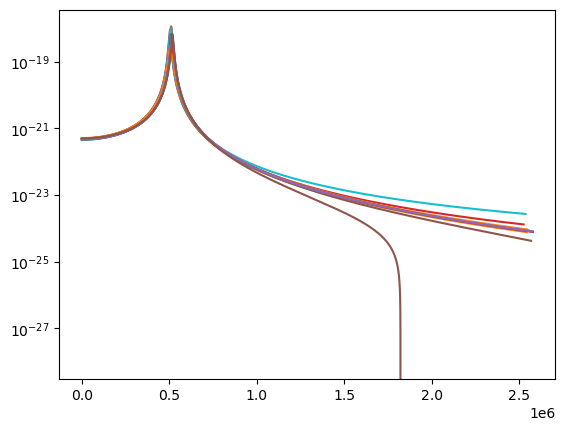

In [372]:
rp_clock = 1/(100e6)
areas_t = []
for folder in folders:
    freq, power = psd('{}/{}'.format(root_folder, folder), factor=1/(11*1.504e4))
    freq_fit, power_fit = extract_fit_interval(freq, power, bottom_limit=7e4, upper_limit=9e4)
    p0 =  [3963600.1039417023, 2*np.pi*79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, 2*np.pi*freq_fit, power_fit, p0=p0, absolute_sigma=True, maxfev=10000)
    
    
    gamma = 13578.7501
    omega = ans[1]
    omegas = np.linspace(0, 5*omega, int(1e5))
    delta_omega = np.diff(omegas)[0]
    gain, delay1, delay2 = [int(param) for param in folder.split('_')]
    total_delay = rp_clock*(delay1+delay2)
    if not (gain in [8191, 8192]):
        gain = convert_gains(gain)
        print(gain)
        theory_psd_s1 = S1(omegas, omega, gamma, gain, total_delay)
        theory_psd_s0 = S0(omegas, omega, gamma)
        areas_t.append(theory_psd_s1.sum()*delta_omega/(theory_psd_s0.sum()*delta_omega))
        print(areas_t)
        plt.plot(omegas, theory_psd_s0)
        plt.plot(omegas, theory_psd_s1)

plt.yscale('log')
    #plt.plot(freq_fit, power_fit)
#plt.plot(freq_fit, lorentzian(2*np.pi*freq_fit, *ans))

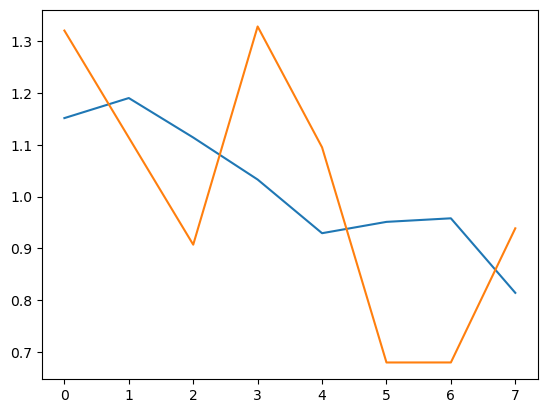

In [374]:
plt.plot(areas)
plt.plot(areas_t)